En este notebook aplicamos **SHAP**

# Libraries

In [38]:
# random
import random as rd

In [39]:
# Data management
try:
    import pandas as pd
except:
    %pip install pandas --quiet
    import pandas as pd

try:
    import numpy as np
except:
    %pip install numpy --quiet
    import numpy as np

import os

In [40]:
# Plots
try:
    import matplotlib.pyplot as plt
except:
    %pip install matplotlib --quiet
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    %pip install seaborn --quiet
    import seaborn as sns
sns.set_style("white")

In [41]:
# Warnings
try:
    import warnings as ws
except:
    %pip install warnings --quiet
    import warnings as ws
ws.filterwarnings("ignore")

In [42]:
# ML
try:
    import xgboost
except:
    %pip install xgboost --quiet
    import xgboost

from sklearn import datasets, ensemble, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.utils.multiclass import unique_labels
from statistics import mean

In [43]:
from xgboost import XGBClassifier

In [44]:
# XAI
# SHAP
try:
  import shap
except:
  %pip install shap --quiet
  import shap
# LIME
try:
  from lime import lime_tabular
except:
  %pip install lime
  from lime import lime_tabular

In [45]:
#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# Functions

In [46]:
# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

def evaluate_model_confusion_matrix(y_true, y_pred, y_score=None, pos_label='positive'): 
  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
#   fig_roc = None
#   if y_score is not None:
#     fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
#     fig_roc = px.area(
#         x=fpr, y=tpr,
#         title={'text' : f'Curva ROC (AUC={auc(fpr, tpr):.4f})', 'x':0.5, 'xanchor': 'center'},
#         labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
#         width=400, height=400
#     )
#     fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

#     fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
#     fig_roc.update_xaxes(constrain='domain')
    
#     fig_roc.show()

In [47]:
def get_comb_aux(elem, list_elems):
    return [] if len(list_elems)==0 else [elem+"_"+list_elems[0]] + get_comb_aux(elem, list_elems[1:len(list_elems)])
    
def get_combinations(list_elems):
    if len(list_elems) <= 1:
        return []
    elif len(list_elems) == 2:
        return [list_elems[0] + "_" + list_elems[1]]
    else:
        return get_comb_aux(list_elems[0], list_elems[1:len(list_elems)]) + get_combinations(list_elems[1:len(list_elems)])

In [48]:
# def eval_fairness(y_pred_a, y_true_a, y_pred_b, y_true_b):
#     data = {}
#     # False Positive Rates FPR = FP / (FP + TN)
#     data['FPR_b'] = np.sum((y_pred_a == 1) * (y_true_a == 0)) / np.sum(y_true_a == 0) #fpr_black
#     data['FPR_w'] = np.sum((y_pred_b == 1) * (y_true_b == 0)) / np.sum(y_true_b == 0) #fpr_white
#     # True positive rates TPR = TP / (TP + FN)
#     data['TPR_b'] = np.sum((y_pred_a == 1)*(y_true_a == 1)) / np.sum(y_true_a == 1) #tpr_black
#     data['TPR_w'] = np.sum((y_pred_b == 1)*(y_true_b == 1)) / np.sum(y_true_b == 1) #tpr_white
#     data['Eq. Oportunity'] = abs(data['TPR_w']-data['TPR_b'])
#     data['Pred. Equality'] = abs(data['FPR_w']-data['FPR_b'])
#     data['Eq. odds'] = abs(data['TPR_w']-data['TPR_b']) + abs(data['FPR_w']-data['FPR_b'])    
#     return data 

In [49]:
def eval_fairness_rates(FPR_a, FPR_b, TPR_a, TPR_b):
    data = {}
    data['Eq.Oportunity'] = abs(TPR_a-TPR_b)
    data['Pred.Equality'] = abs(FPR_a-FPR_b)
    data['Eq.odds'] = data['Eq.Oportunity'] + data['Pred.Equality']
    return data 

In [50]:
def factorial(n): 
    return 1 if (n==1 or n==0) else n * factorial(n - 1)

# Data

In [51]:
# Load processed
current_path = os.getcwd()
dst_path = os.path.join(current_path, "data_dst")
file_name = "processed_compas.csv"
file = os.path.join(dst_path, file_name)
df = pd.read_csv(file)

In [52]:
df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,decile_score.1,v_decile_score,two_year_recid,days_custody,days_c_jail,days_r_jail
0,0,69,0,0,1,0,0,0,1.0,1,0,0,1,1,0,8,2,0
1,0,34,1,0,3,0,0,0,1.0,1,1,1,3,1,1,11,11,0
2,0,24,1,0,4,0,1,4,1.0,1,1,0,4,3,1,1,2,1
3,0,23,1,0,8,1,0,1,1.0,1,0,0,8,6,0,0,0,0
4,0,43,0,0,1,0,0,2,76.0,1,0,0,1,1,0,0,0,0


In [53]:
rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap="coolwarm").format("{:.2f}")

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,decile_score.1,v_decile_score,two_year_recid,days_custody,days_c_jail,days_r_jail
sex,1.00,0.00,0.02,-0.06,-0.06,-0.05,-0.06,-0.12,0.00,-0.05,-0.10,-0.06,-0.06,-0.12,-0.09,-0.04,-0.06,-0.06
age,0.00,1.00,0.12,-0.07,-0.39,-0.12,-0.16,0.14,0.09,-0.09,-0.20,-0.10,-0.39,-0.58,-0.19,-0.01,0.01,-0.05
race,0.02,0.12,1.00,-0.05,-0.17,-0.07,-0.03,-0.12,-0.02,-0.07,-0.09,-0.04,-0.17,-0.18,-0.08,-0.04,-0.02,-0.05
juv_fel_count,-0.06,-0.07,-0.05,1.00,0.18,0.09,0.05,0.18,0.00,0.05,0.09,0.06,0.18,0.17,0.09,0.06,0.06,0.11
decile_score,-0.06,-0.39,-0.17,0.18,1.00,0.22,0.18,0.44,0.03,0.18,0.35,0.17,1.00,0.78,0.35,0.16,0.21,0.19
juv_misd_count,-0.05,-0.12,-0.07,0.09,0.22,1.00,0.27,0.24,0.01,0.03,0.11,0.09,0.22,0.21,0.11,0.03,0.04,0.03
juv_other_count,-0.06,-0.16,-0.03,0.05,0.18,0.27,1.00,0.10,0.00,0.03,0.11,0.05,0.18,0.20,0.11,0.10,0.04,0.02
priors_count,-0.12,0.14,-0.12,0.18,0.44,0.24,0.10,1.00,0.01,0.14,0.28,0.09,0.44,0.21,0.28,0.13,0.20,0.14
c_days_from_compas,0.00,0.09,-0.02,0.00,0.03,0.01,0.00,0.01,1.00,-0.05,-0.07,-0.01,0.03,-0.01,-0.07,0.05,0.02,-0.01
c_charge_degree,-0.05,-0.09,-0.07,0.05,0.18,0.03,0.03,0.14,-0.05,1.00,0.10,-0.01,0.18,0.14,0.11,0.08,0.12,0.09


In [54]:
corr_zip = df[["two_year_recid", "is_recid"]].corr()
corr_zip.style.background_gradient(cmap="coolwarm").format("{:.2f}")

,two_year_recid,is_recid
two_year_recid,1.00,0.94
is_recid,0.94,1.00


In [17]:
df_backup = df.copy()

## Split data

In [18]:
# variables salida
# 1. v_decile_sore
# y1 = df["v_decile_score"]
# df = df.drop(["v_decile_score"], axis=1)
# df = df.drop(["decile_score"], axis=1)
# df = df.drop(["decile_score.1"], axis=1)
# 2. v_decile_text
# y2 = df["v_score_text"]
# df = df.drop(["v_score_text"], axis=1)
# df = df.drop(["score_text"], axis=1)
# 3. two_year_recid
y_two_year_recid = df["two_year_recid"]
df = df.drop(["two_year_recid"], axis=1)
# 4. is_recid
# y3 = df["is_recid"]
# df = df.drop(["is_recid"], axis=1)

In [19]:
# x_data = df.drop(["is_recid"], axis=1)
# y_data = df["is_recid"]

# Experiment 1: SHAP

## is_recid

In [20]:
x_data = df.drop(["is_recid"], axis=1).copy()
y_data = df["is_recid"].copy()

In [21]:
# Split data
x1_train, x1_test, y1_train, y1_test = model_selection.train_test_split(x_data, y_data, random_state=0)
# Model
# m1 = xgboost.XGBRegressor().fit(x1_train, y1_train)
m1 = XGBClassifier().fit(x1_train, y1_train)
# m1 = xgboost.XGBRegressor(enable_categorical=True).fit(x1_train, y1_train)

In [22]:
m1.score(x1_train,y1_train)

0.9482758620689655

In [23]:
y_pred = m1.predict(x1_test)
# y_pred = [0 if y_i < 0.5 else 1 for y_i in y_pred] # para regresores

In [24]:
evaluate_model(y1_test, y_pred)

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       949
           1       0.92      0.79      0.85       849

    accuracy                           0.87      1798
   macro avg       0.88      0.86      0.87      1798
weighted avg       0.87      0.87      0.87      1798

Accuracy -> 86.76%



In [25]:
cm = confusion_matrix(y1_test, y_pred)
cm

array([[890,  59],
       [179, 670]])

In [26]:
# evaluate_model_confusion_matrix(y1_test, y_pred)

In [27]:
# new_row_tmp = {'race': race_tmp, 'TP':cm_tmp[1,1], 'TN':cm_tmp[0,0], 'FP':cm_tmp[1,0], 'FN':cm_tmp[0,1], 'FPR': FPR, 'TPR': TPR}

In [28]:
TN = cm[0,0]
print(f"There are {TN} True Negatives")
TP = cm[1,1]
print(f"There are {TP} True Positives")
FN = cm[0,1]
print(f"There are {FN} False Negatives")
FP = cm[1,0]
print(f"There are {FP} False Positives")

There are 890 True Negatives
There are 670 True Positives
There are 59 False Negatives
There are 179 False Positives


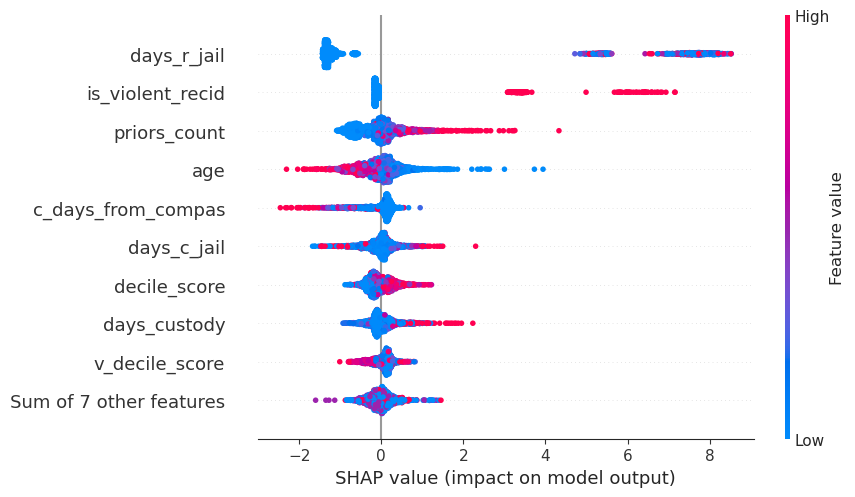

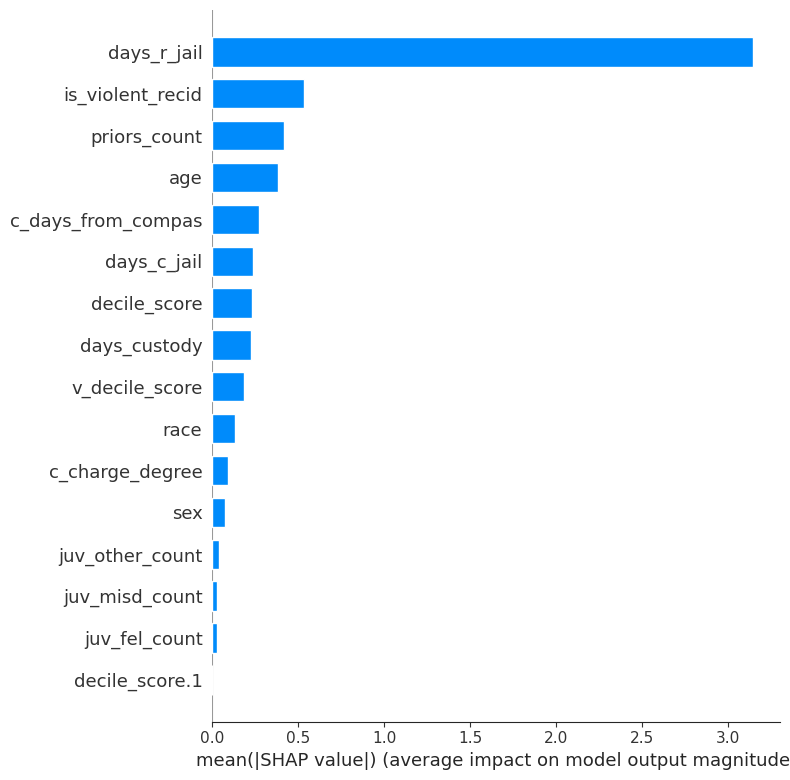

In [29]:
# SHAP
explainer_1 = shap.Explainer(m1)
shap_values_1 = explainer_1(x1_test)
shap.plots.beeswarm(shap_values_1, max_display=10) #summary_plot
shap.summary_plot(shap_values_1, x1_train, plot_type="bar")

## two_years_recid

In [30]:
# Split data
x2_train, x2_test, y2_train, y2_test = model_selection.train_test_split(x_data, y_two_year_recid, random_state=0)
# Model
m2 = XGBClassifier().fit(x2_train, y2_train)
m2.score(x2_train,y2_train)

0.9451242120875046

In [31]:
y_pred_2 = m2.predict(x2_test)

In [32]:
evaluate_model(y2_test, y_pred_2)

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1011
           1       0.88      0.79      0.83       787

    accuracy                           0.86      1798
   macro avg       0.86      0.85      0.86      1798
weighted avg       0.86      0.86      0.86      1798

Accuracy -> 85.98%



In [33]:
cm_2 = confusion_matrix(y2_test, y_pred_2)
cm_2

array([[925,  86],
       [166, 621]])

In [34]:
TN_2 = cm_2[0,0]
print(f"There are {TN_2} True Negatives")
TP_2 = cm_2[1,1]
print(f"There are {TP_2} True Positives")
FN_2 = cm_2[0,1]
print(f"There are {FN_2} False Negatives")
FP_2 = cm_2[1,0]
print(f"There are {FP_2} False Positives")

There are 925 True Negatives
There are 621 True Positives
There are 86 False Negatives
There are 166 False Positives


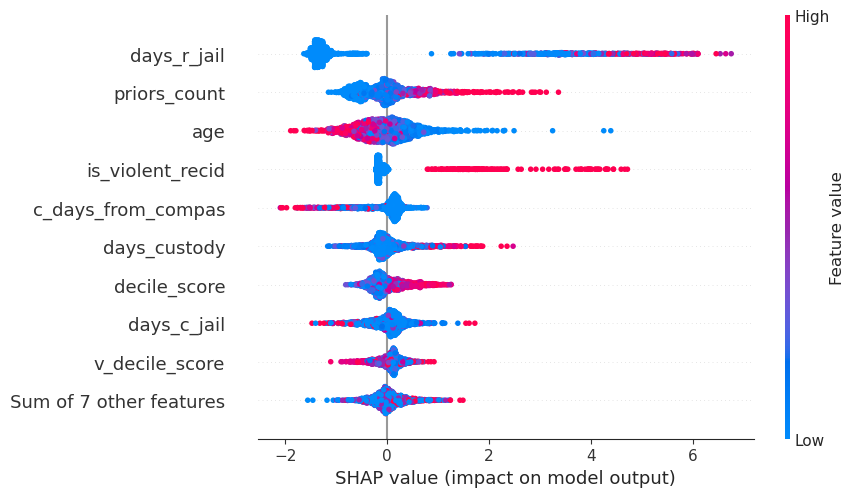

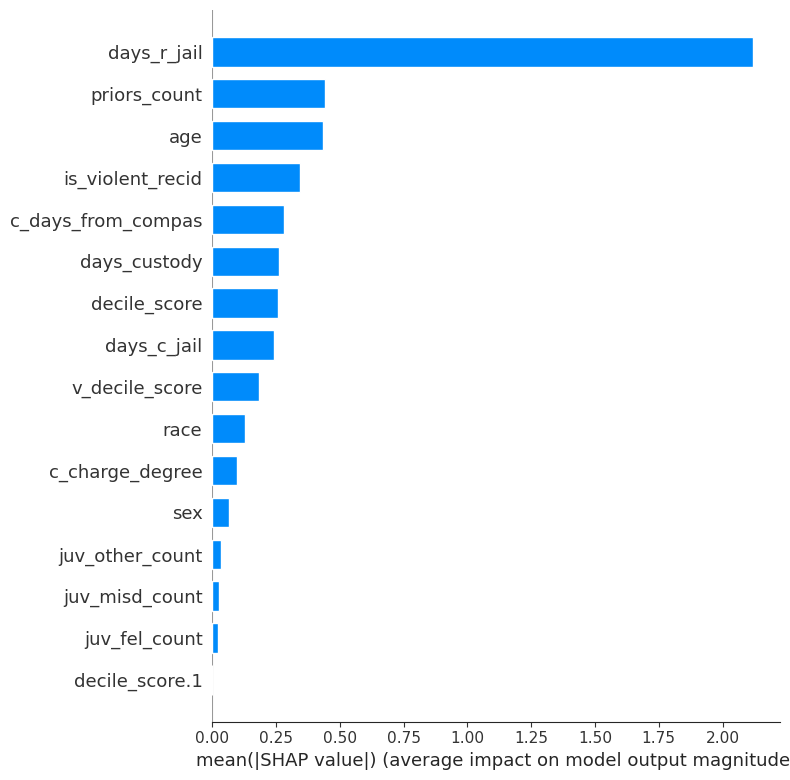

In [81]:
# SHAP
explainer_2 = shap.Explainer(m2)
shap_values_2 = explainer_2(x2_test)
shap.plots.beeswarm(shap_values_2, max_display=10) #summary_plot
shap.summary_plot(shap_values_2, x2_train, plot_type="bar")

# BACKUP

# Fairness

* First, we obtain the TN, TP, FN and FP for each class.
* Second, we create a dataframe with these values.
* Third, we obtan the fairness metrics for each pair.
* Finally, we save them in a new dataframe to show the fairness in the df.


In [29]:
# df.loc[df["race"] == "Other", "race"] = 0
# df.loc[df["race"] == "African-American", "race"] = 1
# df.loc[df["race"] == "Caucasian", "race"] = 2
# df.loc[df["race"] == "Hispanic", "race"] = 3
# df.loc[df["race"] == "Native American", "race"] = 4
# df.loc[df["race"] == "Asian", "race"] = 5

# df.loc[df["sex"] == "Male", "sex"] = 0
# df.loc[df["sex"] == "Female", "sex"] = 1

## Race

In [30]:
# dict
dict_df_race = {0: "other", 1: "african-american", 2: "caucasican", 3: "hispanic", 4: "native-american" , 5: "asian"}
list_races = list(dict_df_race.values())
# df
df_race_other = df[df["race"]==0].copy()
df_race_african_american = df[df["race"]==1].copy()
df_race_caucasican = df[df["race"]==2].copy()
df_race_hispanic = df[df["race"]==3].copy()
df_race_native_american = df[df["race"]==4].copy()
df_race_asian = df[df["race"]==5].copy()
# list of df
list_df = [df_race_other, df_race_african_american, df_race_caucasican,
df_race_hispanic, df_race_native_american, df_race_asian]

In [31]:
# False Positive Rates FPR = FP / (FP + TN)
# True positive rates TPR = TP / (TP + FN)

In [33]:
def get_cm_metrics(list_df, dict_df_race = dict_df_race):
    df_cm_metrics = pd.DataFrame()
    for i in range(len(list_df)):
        race_tmp = dict_df_race[i]
        print(f"The df with id {i} is for the race {race_tmp}")
        df_tmp = list_df[i]
        # split data
        x_data_tmp = df_tmp.drop(["is_recid"], axis=1)
        y_data_tmp = df_tmp["is_recid"]
        x_train_tmp, x_test_tmp, y_train_tmp, y_test_tmp = model_selection.train_test_split(x_data_tmp, y_data_tmp, random_state=0)
        # model
        m_tmp = XGBClassifier().fit(x_train_tmp, y_train_tmp)
        m_tmp.score(x_train_tmp,y_train_tmp)
        # pred and confusion matrix
        y_pred_tmp = np.array(m_tmp.predict(x_test_tmp))
        # y_pred_tmp = np.array([0 if y_i < 0.5 else 1 for y_i in y_pred_tmp]) # para regresores
        cm_tmp = confusion_matrix(y_pred_tmp, y_test_tmp)
        # Rates
        # y_true_tmp = y_test_tmp
        # y_true_tmp = np.array([0 if y_i < 0.5 else 1 for y_i in y_test_tmp]) # para regresores
        # fpr_black = np.sum((y_pred_black == 1) * (y_true_black == 0)) / np.sum(y_true_black == 0)
        FPR_tmp = np.sum((y_pred_tmp == 1) * (y_test_tmp == 0)) / np.sum(y_test_tmp == 0)
        # tpr_black = np.sum((y_pred_black == 1)*(y_true_black == 1)) / np.sum(y_true_black == 1)
        TPR_tmp = np.sum((y_pred_tmp == 1) * (y_test_tmp == 1)) / np.sum(y_test_tmp == 1)
        # Add row to df
        # new_row_tmp = {'race': race_tmp,'FPR': FPR, 'TPR': TPR}
        new_row_tmp = {'race': race_tmp, 'TP':cm_tmp[1,1], 'TN':cm_tmp[0,0], 'FP':cm_tmp[1,0], 'FN':cm_tmp[0,1], 
        'FPR': FPR_tmp, 'FP/(FP+TN)': cm_tmp[1,0]/(cm_tmp[1,0]+cm_tmp[0,0]),
        'TPR': TPR_tmp, 'TP/(TP+FN)': cm_tmp[1,1]/(cm_tmp[1,1]+cm_tmp[0,1])}
        # df_cm_metrics = df_cm_metrics.append(new_row_tmp, ignore_index=True)
        df_cm_metrics = pd.concat(
            [df_cm_metrics, pd.DataFrame([new_row_tmp])],
            ignore_index=True
        )
    return df_cm_metrics

df_cm_metrics = get_cm_metrics(list_df)
# ws.filterwarnings("ignore")

The df with id 0 is for the race other
The df with id 1 is for the race african-american
The df with id 2 is for the race caucasican
The df with id 3 is for the race hispanic
The df with id 4 is for the race native-american
The df with id 5 is for the race asian


In [34]:
df_cm_metrics

,race,TP,TN,FP,FN,FPR,FP/(FP+TN),TPR,TP/(TP+FN)
0,other,24,50,9,11,0.152542,0.152542,0.685714,0.685714
1,african-american,386,383,59,94,0.133484,0.133484,0.804167,0.804167
2,caucasican,202,336,19,56,0.053521,0.053521,0.782946,0.782946
3,hispanic,39,87,9,23,0.093750,0.093750,0.629032,0.629032
4,native-american,1,3,0,1,0.000000,0.000000,0.500000,0.500000
5,asian,2,5,0,1,0.000000,0.000000,0.666667,0.666667


In [36]:
# # Al ser una combinación sin repetición hacemos
# # factorial de n (6) dividido por el factorial de r (2) y el de n-r (4)
# n = len(df_cm_metrics)
# r = 2
# n_iterations = int(factorial(n)/(factorial(r)*factorial(n-r)))
# df
df_fairness = pd.DataFrame()
data_fairness = {}
list_combs = get_combinations(list_races)
for comb in list_combs:
    race_a_tmp, race_b_tmp = comb.split("_")
    # print(f"#### {race_a_tmp} and {race_b_tmp} ####")
    FPR_a_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_a_tmp,"FPR"])[0]
    TPR_a_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_a_tmp,"TPR"])[0]
    FPR_b_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_b_tmp,"FPR"])[0]
    TPR_b_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_b_tmp,"TPR"])[0]
    # data_fairness = list(eval_fairness_rates(FPR_a_tmp, FPR_b_tmp, TPR_a_tmp, TPR_b_tmp)) + data_fairness
    data_fairness[comb] = eval_fairness_rates(FPR_a_tmp, FPR_b_tmp, TPR_a_tmp, TPR_b_tmp)
    new_row_tmp = {'race_comb': comb, 'Eq.Oportunity': data_fairness[comb]['Eq.Oportunity'], 'Pred.Equality':data_fairness[comb]['Pred.Equality'], 'Eq.odds':data_fairness[comb]['Eq.odds']}
    # df_fairness = df_fairness.append(new_row_tmp, ignore_index=True)
    df_fairness = pd.concat(
    [df_fairness, pd.DataFrame([new_row_tmp])],
    ignore_index=True
    )

In [37]:
df_fairness.style.highlight_max(color='red')

,race_comb,Eq.Oportunity,Pred.Equality,Eq.odds
0,other_african-american,0.118452,0.019058,0.137511
1,other_caucasican,0.097231,0.099021,0.196253
2,other_hispanic,0.056682,0.058792,0.115474
3,other_native-american,0.185714,0.152542,0.338257
4,other_asian,0.019048,0.152542,0.171590
5,african-american_caucasican,0.021221,0.079963,0.101184
6,african-american_hispanic,0.175134,0.039734,0.214869
7,african-american_native-american,0.304167,0.133484,0.437651
8,african-american_asian,0.137500,0.133484,0.270984
9,caucasican_hispanic,0.153913,0.040229,0.194142


## TODO: quizá unir con otras columnas como Sex y hacer combinatorias, one-hot + XAI (SHAP)

In [56]:
df_v2 = df.copy()

In [57]:
df = df_backup.copy()

In [58]:
df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,decile_score.1,v_decile_score,two_year_recid,days_custody,days_c_jail,days_r_jail
0,0,69,0,0,1,0,0,0,1.0,1,0,0,1,1,0,8,2,0
1,0,34,1,0,3,0,0,0,1.0,1,1,1,3,1,1,11,11,0
2,0,24,1,0,4,0,1,4,1.0,1,1,0,4,3,1,1,2,1
3,0,23,1,0,8,1,0,1,1.0,1,0,0,8,6,0,0,0,0
4,0,43,0,0,1,0,0,2,76.0,1,0,0,1,1,0,0,0,0


In [59]:
df.columns

Index(['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_days_from_compas',
       'c_charge_degree', 'is_recid', 'is_violent_recid', 'decile_score.1',
       'v_decile_score', 'two_year_recid', 'days_custody', 'days_c_jail',
       'days_r_jail'],
      dtype='object')

In [66]:
def preprocess_for_shap(df):
    df = df.copy()

    # ------------------------------
    # 1) BINNING DE "age"
    # ------------------------------
    bins = [0, 25, 35, 45, 60, 120]
    labels = ["0-25", "26-35", "36-45", "46-60", "60+"]

    df["age_bin"] = pd.cut(df["age"], bins=bins, labels=labels, include_lowest=True)

    # ------------------------------
    # 2) ONE-HOT ENCODING DE race, sex, age_bin
    # drop_first=True evita multicolinealidad
    # ------------------------------
    df_encoded = pd.get_dummies(
        df,
        columns=["race", "sex", "age_bin"],
        drop_first=True
    )

    # ------------------------------
    # 3) Convertir todas las columnas dummies a int (0/1) 
    # ------------------------------
    for col in df_encoded.columns:
        if df_encoded[col].dtype == "bool":
            df_encoded[col] = df_encoded[col].astype(int)

    # ------------------------------
    # 4) Eliminar columnas originales (race, sex, age)
    # ------------------------------
    df_encoded = df_encoded.drop(columns=["race", "sex", "age"], errors="ignore")

    # ------------------------------
    # 5) Asegurar tipos numéricos en todo el DF
    # ------------------------------
    df_encoded = df_encoded.apply(pd.to_numeric, errors="ignore")

    return df_encoded


In [67]:
df_encoded = preprocess_for_shap(df)

In [70]:
df_encoded.head()

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,decile_score.1,...,race_1,race_2,race_3,race_4,race_5,sex_1,age_bin_26-35,age_bin_36-45,age_bin_46-60,age_bin_60+
0,0,1,0,0,0,1.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,3,0,0,0,1.0,1,1,1,3,...,1,0,0,0,0,0,1,0,0,0
2,0,4,0,1,4,1.0,1,1,0,4,...,1,0,0,0,0,0,0,0,0,0
3,0,8,1,0,1,1.0,1,0,0,8,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,2,76.0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [69]:
print(df_encoded.columns)

Index(['juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_days_from_compas', 'c_charge_degree', 'is_recid',
       'is_violent_recid', 'decile_score.1', 'v_decile_score',
       'two_year_recid', 'days_custody', 'days_c_jail', 'days_r_jail',
       'race_1', 'race_2', 'race_3', 'race_4', 'race_5', 'sex_1',
       'age_bin_26-35', 'age_bin_36-45', 'age_bin_46-60', 'age_bin_60+'],
      dtype='object')


In [72]:
df_encoded_backup = df_encoded.copy()

In [ ]:
# Evaluate fairness metrics
# data = eval_fairness(y_pred, y1_test, black_mask, white_mask)

In [73]:
y3_two_year_recid = df_encoded["two_year_recid"]
df_encoded = df_encoded.drop(["two_year_recid"], axis=1)
y4 = df_encoded["is_recid"].copy()
x_encoded_data = df_encoded.drop(["is_recid"], axis=1).copy()

## is_recid

In [74]:
# Split data
x3_train, x3_test, y3_train, y3_test = model_selection.train_test_split(x_encoded_data, y3_two_year_recid, random_state=0)
# Model
m3 = XGBClassifier().fit(x3_train, y3_train)
m3.score(x3_train,y3_train)

0.9382647385984427

In [75]:
y_pred_3 = m3.predict(x3_test)


In [76]:
evaluate_model(y3_test, y_pred_3)

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1011
           1       0.88      0.79      0.83       787

    accuracy                           0.86      1798
   macro avg       0.86      0.85      0.86      1798
weighted avg       0.86      0.86      0.86      1798

Accuracy -> 86.15%



In [77]:
cm_3 = confusion_matrix(y3_test, y_pred_3)
cm_3

array([[925,  86],
       [163, 624]])

In [78]:
TN_3 = cm_3[0,0]
print(f"There are {TN_3} True Negatives")
TP_3 = cm_3[1,1]
print(f"There are {TP_3} True Positives")
FN_3 = cm_3[0,1]
print(f"There are {FN_3} False Negatives")
FP_3 = cm_3[1,0]
print(f"There are {FP_3} False Positives")

There are 925 True Negatives
There are 624 True Positives
There are 86 False Negatives
There are 163 False Positives


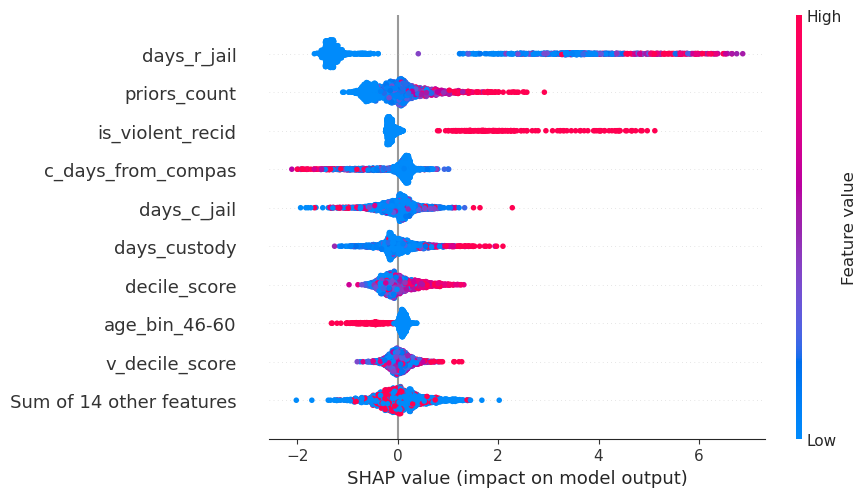

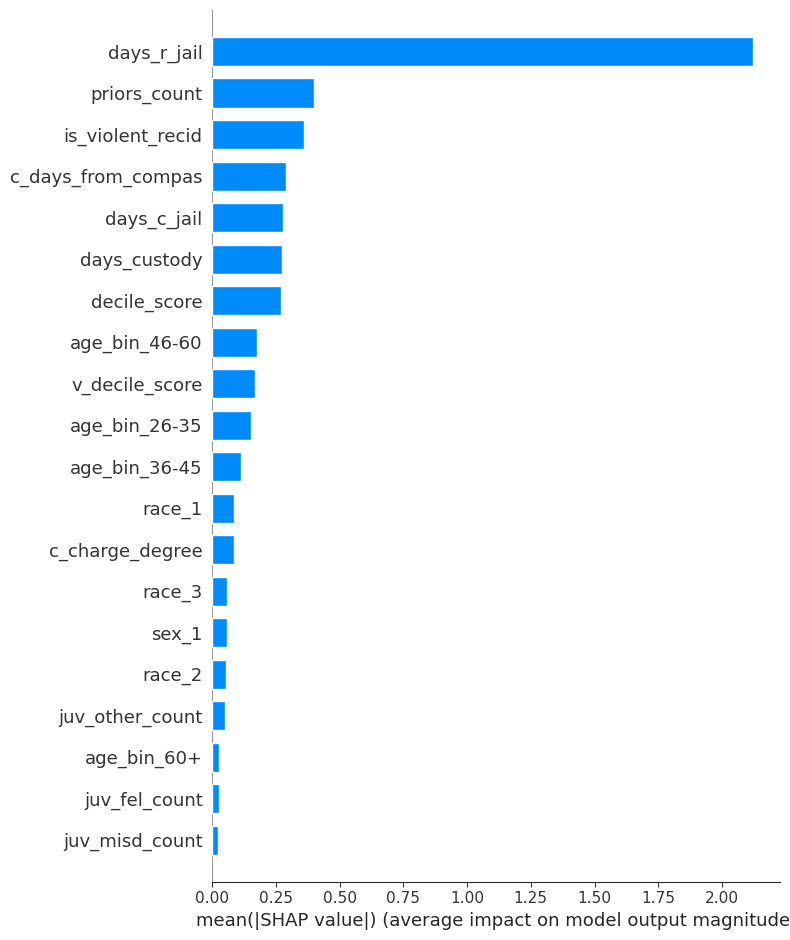

In [ ]:
# SHAP
explainer_3 = shap.Explainer(m3)
shap_values_3 = explainer_3(x3_test)
shap.plots.beeswarm(shap_values_3, max_display=10) #summary_plot
shap.summary_plot(shap_values_3, x3_train, plot_type="bar")

## two_yeaer_recid

In [82]:
# Split data
x4_train, x4_test, y4_train, y4_test = model_selection.train_test_split(x_encoded_data, y4, random_state=0)
# Model
m4 = XGBClassifier().fit(x4_train, y4_train)
m4.score(x4_train,y4_train)

0.9441972562106044

In [83]:
y_pred_4 = m4.predict(x4_test)

In [84]:
evaluate_model(y4_test, y_pred_4)

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       949
           1       0.92      0.79      0.85       849

    accuracy                           0.87      1798
   macro avg       0.87      0.86      0.86      1798
weighted avg       0.87      0.87      0.86      1798

Accuracy -> 86.60%



In [85]:
cm_4 = confusion_matrix(y4_test, y_pred_4)
cm_4

array([[887,  62],
       [179, 670]])

In [86]:
TN_4 = cm_4[0,0]
print(f"There are {TN_4} True Negatives")
TP_4 = cm_4[1,1]
print(f"There are {TP_4} True Positives")
FN_4 = cm_4[0,1]
print(f"There are {FN_4} False Negatives")
FP_4 = cm_4[1,0]
print(f"There are {FP_4} False Positives")

There are 887 True Negatives
There are 670 True Positives
There are 62 False Negatives
There are 179 False Positives


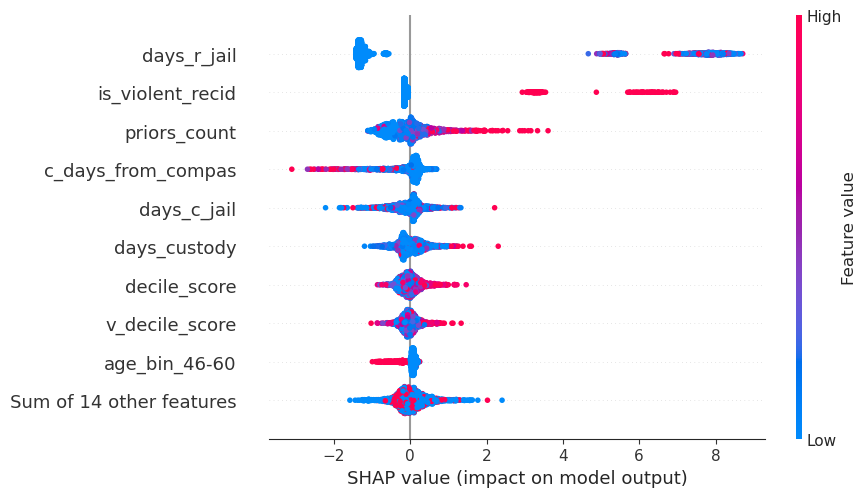

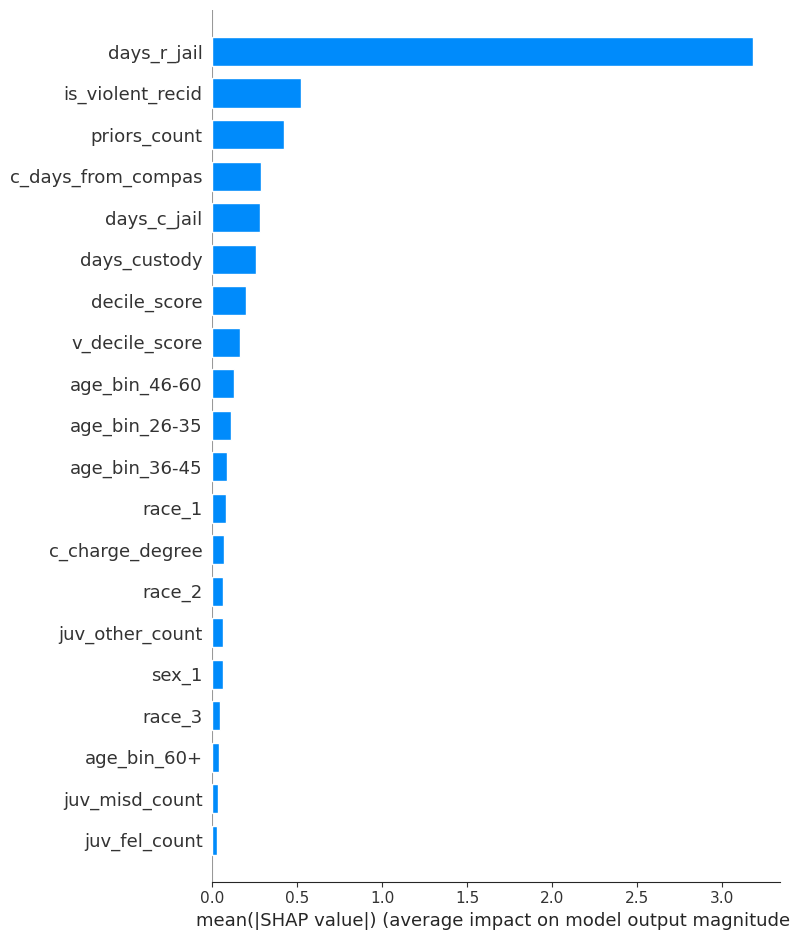

In [87]:
# SHAP
explainer_4 = shap.Explainer(m4)
shap_values_4 = explainer_4(x4_test)
shap.plots.beeswarm(shap_values_4, max_display=10) #summary_plot
shap.summary_plot(shap_values_4, x4_train, plot_type="bar")

# More inside

We analyze the most unfair class dataframe.

### Caucasican + Native American

**important**: It must be automatizated, with the index ot he max value in the df.

In [38]:
n_caucasican = len(df_race_caucasican)
print(f"rows of caucasican {n_caucasican}")
n_native_american = len(df_race_native_american)
print(f"rows of native american {n_native_american}")

rows of caucasican 2449
rows of native american 17


## SHAP: we look for variables

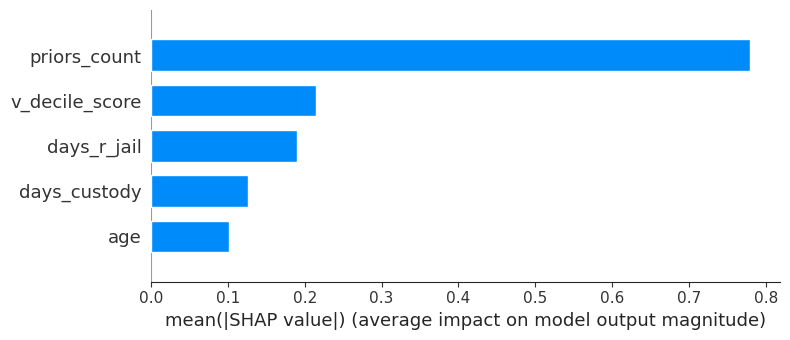

In [39]:
# SHAP native american
# Split data
x_native_american_train, x_native_american_test, y_native_american_train, y_native_american_test = model_selection.train_test_split(df_race_native_american.drop(["is_recid"], axis=1), df_race_native_american["is_recid"], random_state=0)
# Model
m_native_american = XGBClassifier().fit(x_native_american_train, y_native_american_train)
explainer_native_american = shap.Explainer(m_native_american)
shap_values_native_american = explainer_native_american(x_native_american_test)
# shap.plots.beeswarm(shap_values_native_american, max_display=10)
shap.summary_plot(shap_values_native_american, x_native_american_train, plot_type="bar", max_display=5)

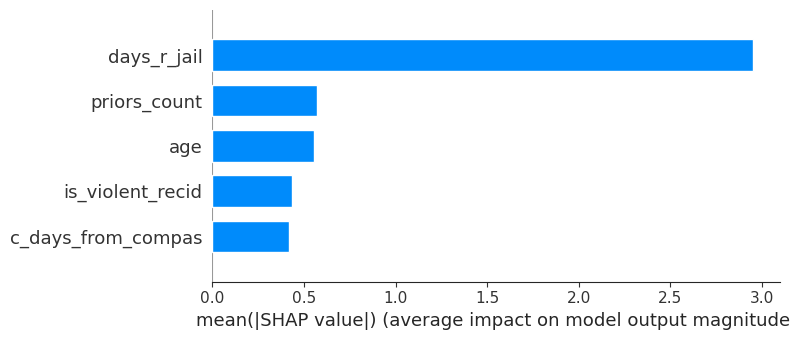

In [40]:
# SHAP caucasican
# Split data
x_caucasican_train, x_caucasican_test, y_caucasican_train, y_caucasican_test = model_selection.train_test_split(df_race_caucasican.drop(["is_recid"], axis=1), df_race_caucasican["is_recid"], random_state=0)
# Model
m_caucasican = XGBClassifier().fit(x_caucasican_train, y_caucasican_train)
explainer_caucasican = shap.Explainer(m_caucasican)
shap_values_caucasican = explainer_caucasican(x_caucasican_test)
# shap.plots.beeswarm(shap_values_caucasican, max_display=10)
shap.summary_plot(shap_values_caucasican, x_caucasican_train, plot_type="bar", max_display=5)
# Tiene sentido que la race tenga más peso que antes al ser un valor categórico entre dos clasees en lugar de 6

# Conclusions

1. Problemas con el balanceo de datos: cantidad insuficiente en algunas clases
2. Tras hacer nuestro balanceo propuesto la desigualdad se ha reducido a aproximadamente la mitad.


El **problema** es la falta de datos en algunos dominios. La **propuesta** es una técnica de aumentado en función de las correlaciones para aportar sentido al aumentado y reducir la injusticia (Ethical AI). Además, **XAI** ha sido utilizado para apreciar como tras el aumentado de datos los pesos tienen más sentido.

## Future work

1. Observar la frecuencia de las muestras para generar nuevos datos, no sólo las correlaciones. -> YA SE ESTÁ HACIENDO SI NO SE QUITAN LOS DUPLICADOS AL SACAR LOS ÍNDICES
2. Validar con otro dataset midiendo el accuracy antes y después de la aplicación de COCOS.
3. Hacer librería COCOS para su uso (tipo SMOTE).
4. ¿Sería la "semilla"? Es decir, que en base a este artículo salga uno más grande con la prueba de todo y lo comentado aquí.
5. Podría haber incoherencias, es encesario revisar con conocimiento de dominio. -> pasar lista de condiciones por parámetro y si no cumple todas borrar la fila; también pasar el max it.